
**Название проекта: Определение стоимости машины по ее VIN коду**\
**Описание проекта:** При отсутствии какой-либо полезной информации о машине, кроме ее VIN кода, необходимо выявить насколько возможно предсказать ее цену.\
**Данные:** Текстовый файл с VIN-кодами и соответствующими ценами.\
**Цели:** нужно спрогнозировать цену автомобиля\
**Задачи:** \
1) Изучить структуру VIN-кода, какие информационные компоненты он содержит (регион, производитель, характеристики автомобиля и т. д.)\
2) составить регулярные выражения для поиска и извлечения конкретных частей VIN-кода, таких как производитель, модель и год выпуска. Декодировать VIN-код.\
3) Построить модель с предельно меньшими значениеми метрик RMSE и MAPE.

Общий итог размещен в конце исследования.

In [184]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [185]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb
import xgboost as xgb

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from catboost.utils import get_confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [186]:
TEST_SIZE = 0.20
RANDOM_STATE = 170723

In [187]:
with open ('/content/drive/My Drive/Colab Notebooks/vin_ford_train.txt', 'r') as f:
    data = f.read()
data[:300]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZU64W13UC28949:2900][2FMDK3JC9DBB30736:23500][1FMCU'

In [188]:
allowed_chars = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')] # Символы Q, I и O не используются при кодировке. Это сделано для того, чтобы клиенты не путали их с цифрами и вероятность мошенничества к минимуму.
allowed_numbers = [str(x) for x in range (1,10)] + ['0']
allowed = ''.join(allowed_chars+allowed_numbers)
allowed

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

In [189]:
wmi_re = f'(?P<wmi>[{allowed}]{{3}})' # 1-3 символы - WMI: география производства машины.
restraint_re = f'(?P<restraint>[{allowed}])' # 4 тормозная система (система безопасности)
model_re = f'(?P<model>[{allowed}]{{3}})' # 5-7 # модель машины\линия(серия)\тип кузова
engine_re = f'(?P<engine>[{allowed}])' # 8 вид двигателя
check_re = f'(?P<check>[{allowed}])' # 9 контрольная цифра
year_re = f"(?P<year>[{allowed.replace('U', '').replace('Z', '')}])" # 10 год выпуска автомобиля
plant_re = f'(?P<plant>[{allowed}])' # 11 завод-изготовитель (сборочный завод)
vis_re = f'(?P<vis>[{allowed}]{{3}}\\d{{3}})' # 12 -17 месяц + модельный год (серийный номер автомобиля) уникальный производственный номер машины

vin_re = f'{wmi_re}{restraint_re}{model_re}{engine_re}{check_re}{year_re}{plant_re}{vis_re}'

price_re= r'(?P<price>\d+)'


In [190]:
data_re = re.compile(f'\\[{vin_re}:{price_re}\\]')

In [191]:
values = []
for obj in data_re.finditer(data):
  values.append(obj.groupdict())
values[:1]


[{'wmi': '2FM',
  'restraint': 'D',
  'model': 'K3J',
  'engine': 'C',
  'check': '4',
  'year': 'B',
  'plant': 'B',
  'vis': 'A41556',
  'price': '12500'}]

In [192]:
data = pd.DataFrame(values)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


,wmi,restraint,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [193]:
data['price'] = data['price'].astype('int')

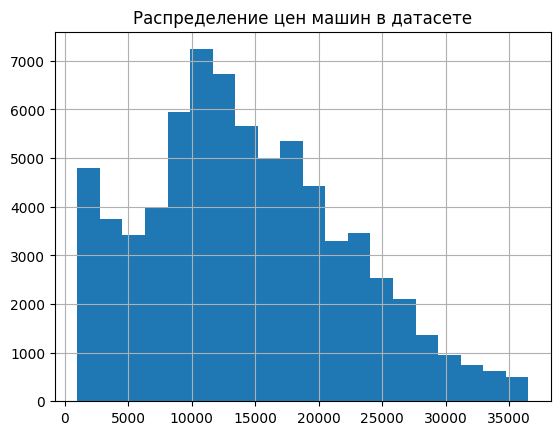

In [194]:
data['price'].hist(bins = 20).set(title = 'Распределение цен машин в датасете');
plt.show();

Тут нужно графики долей% для остальных качественных признаков построить, сделать по ним вывод.

In [195]:
for column in data.columns:
    print(column, len(data[column].unique()))

wmi 14
restraint 26
model 365
engine 32
check 11
year 25
plant 21
vis 68215
price 643


Есть неинформативный признак уникального производственного номера машины, там 68 тыс. уникальных значений. Его в обучение модели не берем.

In [196]:
features = data.drop('price', axis=1).columns
features

Index(['wmi', 'restraint', 'model', 'engine', 'check', 'year', 'plant', 'vis'], dtype='object')

In [197]:
data[features] = data[features].astype('category')

In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   wmi        71884 non-null  category
 1   restraint  71884 non-null  category
 2   model      71884 non-null  category
 3   engine     71884 non-null  category
 4   check      71884 non-null  category
 5   year       71884 non-null  category
 6   plant      71884 non-null  category
 7   vis        71884 non-null  category
 8   price      71884 non-null  int64   
dtypes: category(8), int64(1)
memory usage: 3.9 MB


In [199]:
data = data.drop('vis', axis=1)

In [200]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop('price', axis=1), data.price, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [201]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(57507, 7)
(14377, 7)
(57507,)
(14377,)


**XGB**

In [202]:
%%time

clf = xgb.XGBRegressor(random_state=RANDOM_STATE, enable_categorical=True) # enable_categorical=True - чтобы модель принимала данные типа category

parameters = {
     'n_estimators': [400],                        # число деревьев в лесу   n_estimators : range (50, 141, 30)
     'eta'    : [0.3],                             # learning rate - скорость обучения (псевдоним:eta)
     'max_depth'   : [ 3, 5, 7],                   # глубина дерева        max_depth : range (6, 22, 5) - можно и так
      }

grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=3, verbose=2) # запускаем обучение

grid.fit(features_train, target_train)

print(grid.best_params_)   # выводим результат лучших параметров
print((grid.best_score_)*(-1))   # выводим лучшее значение метрики
table_of_results = pd.DataFrame(grid.cv_results_)
print()
table_of_results

Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'eta': 0.3, 'max_depth': 3, 'n_estimators': 400}
2831.212298266581

CPU times: user 4.73 s, sys: 168 ms, total: 4.9 s
Wall time: 40.1 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.964690,0.769017,0.549483,0.113427,0.3,3,400,"{'eta': 0.3, 'max_depth': 3, 'n_estimators': 400}",-2836.119475,-2859.249521,-2798.267899,-2831.212298,25.136293,1
1,5.135787,0.103200,0.891992,0.330824,0.3,5,400,"{'eta': 0.3, 'max_depth': 5, 'n_estimators': 400}",-2944.581908,-2968.376052,-2924.592970,-2945.850310,17.896857,2
2,10.080600,1.307687,1.151816,0.224479,0.3,7,400,"{'eta': 0.3, 'max_depth': 7, 'n_estimators': 400}",-3077.583543,-3077.110972,-3064.465522,-3073.053346,6.075573,3


In [203]:
%%time

clf = xgb.XGBRegressor(random_state=RANDOM_STATE, enable_categorical=True) # enable_categorical=True - чтобы модель принимала данные типа category

parameters = {
     'n_estimators': [400],                        # число деревьев в лесу   n_estimators : range (50, 141, 30)
     'eta'    : [0.3],                             # learning rate - скорость обучения (псевдоним:eta)
     'max_depth'   : [2, 3, 5, 7],                   # глубина дерева        max_depth : range (6, 22, 5) - можно и так
      }

grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', cv=3, verbose=2) # запускаем обучение

grid.fit(features_train, target_train)

print(grid.best_params_)   # выводим результат лучших параметров
print((grid.best_score_)*(-1))   # выводим лучшее значение метрики
table_of_results = pd.DataFrame(grid.cv_results_)
print()
table_of_results

Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'eta': 0.3, 'max_depth': 2, 'n_estimators': 400}
0.20214004215559

CPU times: user 3.54 s, sys: 116 ms, total: 3.66 s
Wall time: 40.7 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.956460,0.020889,0.287635,0.007173,0.3,2,400,"{'eta': 0.3, 'max_depth': 2, 'n_estimators': 400}",-0.200209,-0.206068,-0.200143,-0.202140,0.002778,1
1,3.857234,0.803978,0.529799,0.121226,0.3,3,400,"{'eta': 0.3, 'max_depth': 3, 'n_estimators': 400}",-0.204757,-0.209538,-0.204458,-0.206251,0.002327,2
2,5.160055,0.130519,0.819407,0.210595,0.3,5,400,"{'eta': 0.3, 'max_depth': 5, 'n_estimators': 400}",-0.213280,-0.218664,-0.215057,-0.215667,0.002240,3
3,10.406995,1.024500,1.256310,0.102850,0.3,7,400,"{'eta': 0.3, 'max_depth': 7, 'n_estimators': 400}",-0.224729,-0.225803,-0.225573,-0.225368,0.000462,4


**CatBoost**

In [204]:
category = ['wmi', 'restraint', 'model', 'engine', 'check', 'year', 'plant']

In [205]:
%%time

model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=100) # verbose - какая кратность итериций будет выводиться для инфы

parametrs = { 'n_estimators': [400],        # число деревьев в лесу
              'max_depth': [2, 3, 4, 5],      # потому что бустинговые модели лучше работают на ПЕНЬКАХ
               'learning_rate': [0.3]} # learning_rate - скорость обучения (от 0 до 1)

grid = GridSearchCV(model, parametrs, n_jobs=-1, cv=3, scoring = 'neg_root_mean_squared_error', verbose=3)   # запускаем обучение

grid.fit(features_train, target_train, cat_features=category)

print(grid.best_params_)   # выводим результат лучших параметров
print((grid.best_score_)*(-1))   # выводим лучшее значение метрики
table_of_results = pd.DataFrame(grid.cv_results_)
print()
table_of_results

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0:	learn: 6293.3369246	total: 149ms	remaining: 59.5s
100:	learn: 2838.5573523	total: 5.27s	remaining: 15.6s
200:	learn: 2780.8609380	total: 9.32s	remaining: 9.22s
300:	learn: 2751.3146776	total: 14.4s	remaining: 4.72s
399:	learn: 2730.7529393	total: 19.8s	remaining: 0us
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 400}
2808.363606656849

CPU times: user 33 s, sys: 1.02 s, total: 34 s
Wall time: 2min 24s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,8.614572,0.352413,0.074499,0.020613,0.3,2,400,"{'learning_rate': 0.3, 'max_depth': 2, 'n_esti...",-2925.150523,-2951.919041,-2893.385868,-2923.485144,23.925066,4
1,16.934568,2.643974,0.097919,0.030064,0.3,3,400,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",-2854.145193,-2874.040496,-2822.737943,-2850.307877,21.119213,3
2,24.836186,0.539486,0.115047,0.037162,0.3,4,400,"{'learning_rate': 0.3, 'max_depth': 4, 'n_esti...",-2830.468770,-2849.036164,-2788.179601,-2822.561511,25.465976,2
3,29.875523,4.880246,0.078728,0.011922,0.3,5,400,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",-2813.821254,-2835.671805,-2775.597761,-2808.363607,24.826896,1


In [206]:
%%time

model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=100) # verbose - какая кратность итериций будет выводиться для инфы

parametrs = { 'n_estimators': [400],        # число деревьев в лесу
              'max_depth': [2, 3, 4, 5],     # потому что бустинговые модели лучше работают на ПЕНЬКАХ
               'learning_rate': [0.3]} # learning_rate - скорость обучения (от 0 до 1)

grid = GridSearchCV(model, parametrs, n_jobs=-1, cv=3, scoring = 'neg_mean_absolute_percentage_error', verbose=2)   # запускаем обучение

grid.fit(features_train, target_train, cat_features=category)


print(grid.best_params_)   # выводим результат лучших параметров
print((grid.best_score_)*(-1))   # выводим лучшее значение метрики
table_of_results = pd.DataFrame(grid.cv_results_)
print()
table_of_results

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0:	learn: 6293.3369246	total: 63.7ms	remaining: 25.4s
100:	learn: 2838.5573523	total: 4.28s	remaining: 12.7s
200:	learn: 2780.8609380	total: 9.76s	remaining: 9.66s
300:	learn: 2751.3146776	total: 14.2s	remaining: 4.66s
399:	learn: 2730.7529393	total: 19.7s	remaining: 0us
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 400}
0.2095872806088522

CPU times: user 32.8 s, sys: 965 ms, total: 33.8 s
Wall time: 2min 4s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,8.684862,0.172899,0.059114,0.011790,0.3,2,400,"{'learning_rate': 0.3, 'max_depth': 2, 'n_esti...",-0.218617,-0.223231,-0.218819,-0.220222,0.002129,4
1,13.801235,0.070368,0.092278,0.024455,0.3,3,400,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",-0.213331,-0.214592,-0.210696,-0.212873,0.001623,3
2,20.363936,0.926814,0.083121,0.010543,0.3,4,400,"{'learning_rate': 0.3, 'max_depth': 4, 'n_esti...",-0.210478,-0.214156,-0.206632,-0.210422,0.003072,2
3,24.709186,3.654812,0.083259,0.034820,0.3,5,400,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",-0.208173,-0.213919,-0.206669,-0.209587,0.003124,1


**LightGBM**

для LightGBMRegressor требуется, присвоит тип данных
'category', чтобы он распознал категориальные данные

In [207]:
%%time
model = lgb.LGBMRegressor(random_state=RANDOM_STATE, verbose=100) # verbose - какая кратность итериций будет выводиться для инфы

parametrs = { 'n_estimators': [400],   # число деревьев в лесу
              'max_depth': [2, 3, 4, 5],            # глубина дерева
               'learning_rate': [0.3],           # learning_rate - скорость обучения (от 0 до 1)
               'force_col_wise': [True],
               'num_leaves' : [129],       # Чтобы дерево гарантированно достигало глубины нужно num_leaves сделать
                'num_threads':[1]}         # равным 2^max_depth.  Но не факт, что это улучшит работу модели и может
                                           # только утяжелить модель. Можно попробовать разные варианты:
                                           # дефолтное значение 31, какое-нибудь среднее значение, и 2^10 например.
grid = GridSearchCV(model, parametrs, n_jobs=-1, cv=3, scoring = 'neg_root_mean_squared_error', verbose=0) # запускаем обучение

grid.fit(features_train, target_train)

print(grid.best_params_)   # выводим результат лучших параметров
print((grid.best_score_)*(-1))   # выводим лучшее значение метрики
table_of_results = pd.DataFrame(grid.cv_results_)
print()
table_of_results

[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 57507, number of used features: 7
[LightGBM] [Info] Start training from score 14323.120107
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_force_col_wise,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,param_num_threads,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.948877,0.028119,0.344665,0.011493,True,0.3,2,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",-2804.243716,-2837.826582,-2769.154117,-2803.741472,28.037666,1
1,1.143296,0.019707,0.474622,0.008260,True,0.3,3,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",-2810.145553,-2851.669063,-2777.358179,-2813.057598,30.407092,2
2,1.495958,0.058178,0.676328,0.042989,True,0.3,4,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",-2847.710643,-2880.344416,-2811.843067,-2846.632708,27.975944,3
3,2.319110,0.344075,0.913587,0.201318,True,0.3,5,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",-2881.749881,-2913.261671,-2852.757757,-2882.589770,24.707758,4


In [208]:
%%time
model = lgb.LGBMRegressor(random_state=RANDOM_STATE, verbose=100) # verbose - какая кратность итериций будет выводиться для инфы

parametrs = { 'n_estimators': [400],   # число деревьев в лесу
              'max_depth': [2, 3, 4, 5],            # глубина дерева
               'learning_rate': [0.3],           # learning_rate - скорость обучения (от 0 до 1)
               'force_col_wise': [True],
               'num_leaves' : [129],       # Чтобы дерево гарантированно достигало глубины нужно num_leaves сделать
                'num_threads':[1]}         # равным 2^max_depth.  Но не факт, что это улучшит работу модели и может
                                           # только утяжелить модель. Можно попробовать разные варианты:
                                           # дефолтное значение 31, какое-нибудь среднее значение, и 2^10 например.
grid = GridSearchCV(model, parametrs, n_jobs=-1, cv=3, scoring = 'neg_mean_absolute_percentage_error', verbose=0) # запускаем обучение

grid.fit(features_train, target_train)

print(grid.best_params_)   # выводим результат лучших параметров
print((grid.best_score_)*(-1))   # выводим лучшее значение метрики
table_of_results = pd.DataFrame(grid.cv_results_)
print()
table_of_results

[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 57507, number of used features: 7
[LightGBM] [Info] Start training from score 14323.120107
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_force_col_wise,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,param_num_threads,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.022443,0.052997,0.377659,0.016231,True,0.3,2,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",-0.205948,-0.208118,-0.204141,-0.206069,0.001626,2
1,1.160789,0.026842,0.510913,0.008324,True,0.3,3,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",-0.204815,-0.207894,-0.202561,-0.205090,0.002186,1
2,1.494687,0.020307,0.717004,0.061787,True,0.3,4,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",-0.207759,-0.211414,-0.206048,-0.208407,0.002238,3
3,2.285254,0.309783,1.134948,0.295030,True,0.3,5,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",-0.209668,-0.213949,-0.209802,-0.211140,0.001987,4


**Итоги работы моделей:**

In [209]:
models = {
    "Model": [
        "Бустинг XGB",
        "Бустинг CatBoost",
        "Бустинг LGBM"
    ],
    "Лучший показатель метрики RMSE": [2831, 2808, 2803],
    "Лучший показатель метрики MAPE": [0.2021, 0.2095, 0.2050],

}

df = pd.DataFrame(models)
display(df)

,Model,Лучший показатель метрики RMSE,Лучший показатель метрики MAPE
0,Бустинг XGB,2831,0.2021
1,Бустинг CatBoost,2808,0.2095
2,Бустинг LGBM,2803,0.2050


**Исходя из данных лучшая модель это :  Бустинг LGBM**

**Ее гиперпараметры: , 2 - глубина дерева, 400 - количество деревьев, learning_rate - 0.3**

**Тестирование самой успешной модели**

In [210]:
%%time

model = lgb.LGBMRegressor(custom_loss = 'neg_root_mean_squared_error', n_estimators= 400, max_depth = 2, learning_rate = 0.3, num_leaves = 129, random_state=RANDOM_STATE, verbose=100)

model.fit(features_train, target_train)

predictions = model.predict(features_test) # Получим предсказания модели

print('Значение LGBM метрики RMSE:', mean_squared_error(target_test, predictions)**0.5)

[LightGBM] [Warning] Unknown parameter: custom_loss
[LightGBM] [Warning] Unknown parameter: custom_loss
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.050928
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.004457 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 57507, number of used features: 7
[LightGBM] [Info] Start training from score 14323.120107
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM]

In [211]:
%%time

model = lgb.LGBMRegressor(custom_loss = 'neg_mean_absolute_percentage_error', n_estimators= 400, max_depth = 2, learning_rate = 0.3, num_leaves = 129, random_state=RANDOM_STATE, verbose=100)

model.fit(features_train, target_train)

predictions = model.predict(features_test) # Получим предсказания модели

print('Значение LGBM метрики RMSE:', mean_absolute_percentage_error(target_test, predictions))

[LightGBM] [Warning] Unknown parameter: custom_loss
[LightGBM] [Warning] Unknown parameter: custom_loss
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.050928
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.004076 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 57507, number of used features: 7
[LightGBM] [Info] Start training from score 14323.120107
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM]

**Метрика MAPE на тестовой выборке равна 2756**\
**Метрика MAPE на тестовой выборке равна 0.2032**

**Важность признаков**

In [212]:
print(model.feature_importances_)

[ 55 116 377 279  61 213  64]


In [213]:
importances = pd.DataFrame({'col_name': model.feature_importances_}, index=features_test.columns).sort_values(by='col_name', ascending=False)
importances

,col_name
model,377
engine,279
year,213
restraint,116
plant,64
check,61
wmi,55


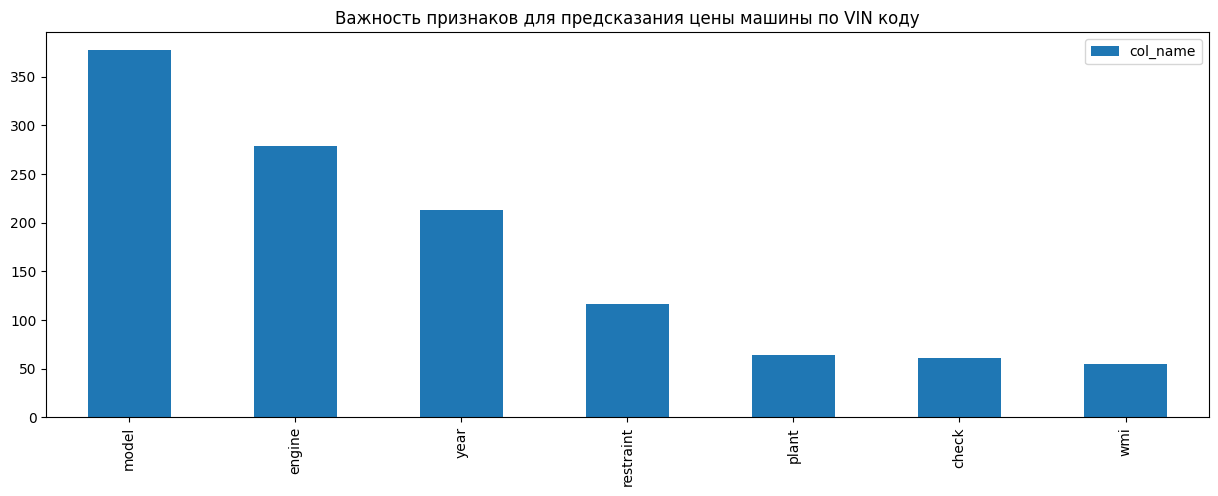

In [214]:
importances.plot(kind='bar', figsize=(15,5)).set(title = 'Важность признаков для предсказания цены машины по VIN коду', label = 'коэф. важности')
plt.show();

**Самый значимый признак для предсказания цены машины по VIN коду это ее модель и тип двигателя**

**Проверка лучшей модели на адекватность**

**Константная модель**

In [215]:
dummy_clf = DummyRegressor(strategy="mean")
dummy_clf.fit(features_train, target_train) # обучаем модель на обучающей выборке
dummy_predictions = dummy_clf.predict(features_test) # получаем предсказания модели на тестовой выборке

result_1 = mean_squared_error(dummy_predictions, target_test)**0.5
result_2 = mean_absolute_percentage_error(dummy_predictions, target_test)

print("RMSE на тестовой выборке константной модели:" , result_1)
print("MAPE на тестовой выборке константной модели:", result_2)

RMSE на тестовой выборке константной модели: 7859.087666215617
MAPE на тестовой выборке константной модели: 0.4471470252452262


***Напишите класс или функцию, которая на вход принимает VIN-код (список кодов или строку), выдает информацию об автомобиле и предсказанную стоимость***



Честно говоря, немного не понимаю как это должно выглядеть и работать, есть ли какой-то пример?